In [1]:
!pip install jupysql clickhouse_sqlalchemy matplotlib python-dotenv pandas seaborn imageio > /dev/null 2>&1

In [2]:
import dotenv
import os
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imageio

dotenv.load_dotenv()

# Load and display config
start_date = os.getenv('START_DATE_TIME')
if not start_date:
    raise ValueError("START_DATE_TIME environment variable is required")

end_date = os.getenv('END_DATE_TIME')
if not end_date:
    end_date = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")

network = os.getenv('NETWORK')

print(f"start_date: {start_date}")
print(f"end_date: {end_date}")

# Convert start and end dates to datetime objects
try:
    start_dt = datetime.fromisoformat(start_date.replace("Z", "+00:00"))
except ValueError as e:
    raise ValueError(f"Invalid start date format. Date must be in ISO format. Error: {str(e)}")

try:
    if isinstance(end_date, datetime):
        end_dt = end_date
    else:
        end_dt = datetime.fromisoformat(str(end_date).replace("Z", "+00:00"))
except ValueError as e:
    raise ValueError(f"Invalid end date format. Date must be in ISO format. Error: {str(e)}")

# Calculate the difference in hours
hours = (end_dt - start_dt).total_seconds() / 3600

print(f"hours: {hours}")

start_date: 2024-11-30T00:00:00Z
end_date: 2024-12-03T14:32:10Z
hours: 86.53611111111111


In [3]:
# Connect to ClickHouse
import os
from sqlalchemy import create_engine, text

username = os.getenv('XATU_CLICKHOUSE_USERNAME')
password = os.getenv('XATU_CLICKHOUSE_PASSWORD')
host = os.getenv('XATU_CLICKHOUSE_HOST')

print(f"username: {username}")
print(f"host: {host}")

db_url = f"clickhouse+http://{username}:{password}@{host}:443/default?protocol=https"
engine = create_engine(db_url)
connection = engine.connect()

username: pandaops
host: clickhouse.xatu.ethpandaops.io


In [4]:
all_slots_query = text("""
    SELECT DISTINCT
        slot,
        meta_client_name as client,
        slot_start_date_time as time,
        propagation_slot_start_diff as arrival_time
    FROM beacon_api_eth_v1_events_block FINAL 
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = :network
        AND NOT meta_client_name LIKE 'ethpandaops%'
        AND propagation_slot_start_diff <= 6000  -- Limit arrival time to max 6000 seconds
    GROUP BY
        time,
        slot,
        client,
        arrival_time
    ORDER BY slot ASC
""")

result = connection.execute(all_slots_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', ''), "network": network})
all_slots = pd.DataFrame(result.fetchall(), columns=['slot', 'client', 'time', 'arrival_time'])
# Extract username from client string
all_slots['username'] = all_slots['client'].str.extract(r'(?:[^/]+/)([\w-]+)/')
all_slots['node_hash'] = all_slots['client'].str.extract(r'hashed-([a-f0-9]+)')

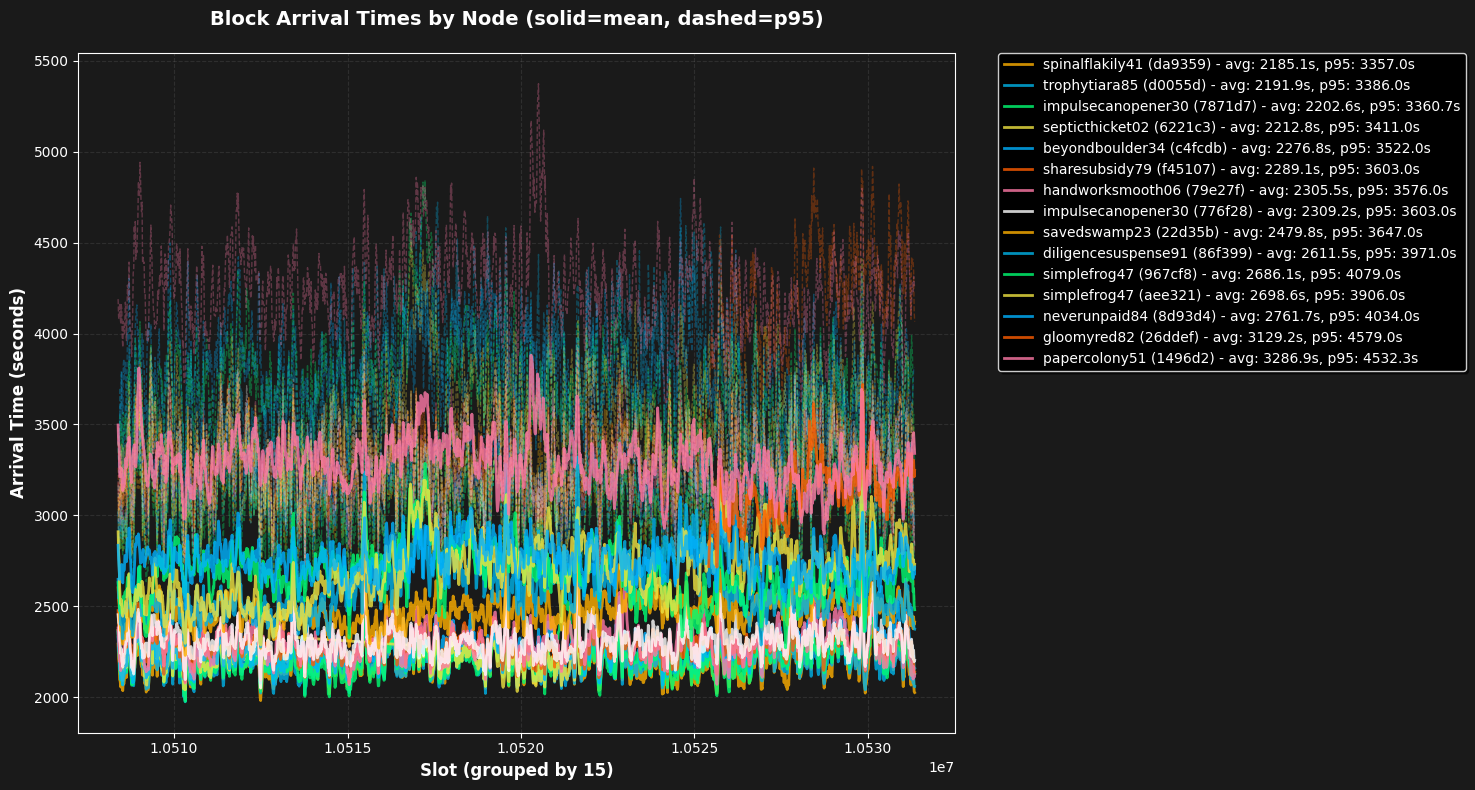

In [5]:
# Group data into buckets of 15 slots
all_slots['slot_bucket'] = (all_slots['slot'] // 15) * 15

# Calculate metrics with rolling average
avg_by_node = (
    all_slots.groupby(['slot_bucket', 'username', 'node_hash'])
    .agg({'arrival_time': 'mean'})
    .reset_index()
)
avg_by_node.columns = ['slot_bucket', 'username', 'node_hash', 'mean_arrival']

node_stats = (
    all_slots.groupby(['username', 'node_hash'])
    .agg({'arrival_time': 'mean'})
    .sort_values('arrival_time')
)
node_stats.columns = ['mean_arrival']

# Create plot with a dark style
plt.style.use('dark_background')
plt.figure(figsize=(15, 8), dpi=100)

colors = ['#FFB000', '#00B4E9', '#00FF73', '#F0E442', '#00B2FF', '#FF5E00', '#FF79A7', '#FFFFFF']

# Plot each node's line with smoothing
for i, (username, node_hash) in enumerate(node_stats.index):
    node_data = avg_by_node[
        (avg_by_node['username'] == username) & 
        (avg_by_node['node_hash'] == node_hash)
    ]
    avg_time = node_stats.loc[(username, node_hash), 'mean_arrival']
    
    # Apply rolling average smoothing
    smoothed_data = node_data['mean_arrival'].rolling(window=5, center=True, min_periods=1).mean()
    
    color = colors[i % len(colors)]
    plt.plot(
        node_data['slot_bucket'],
        smoothed_data,
        color=color,
        alpha=0.8,
        linewidth=2,
        label=f"{username} ({node_hash[:6]}) - avg: {avg_time:.1f}s"
    )

plt.grid(True, alpha=0.2, linestyle='--', color='gray')
plt.xlabel('Slot (grouped by 15)', fontsize=12, fontweight='bold')
plt.ylabel('Arrival Time (seconds)', fontsize=12, fontweight='bold')
plt.title('Block Arrival Times by Node (mean)', fontsize=14, fontweight='bold', pad=20)

plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    frameon=True,
    fancybox=True,
    shadow=True,
    fontsize=10
)

plt.gca().set_facecolor('#1a1a1a')
plt.gcf().patch.set_facecolor('#1a1a1a')

plt.tight_layout()
plt.show()
